In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.colors import ListedColormap
from sklearn.metrics import confusion_matrix#, silhouette_samples, silhouette_score
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA, KernelPCA, FactorAnalysis, SparsePCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn import tree
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import Pipeline
from sklearn.gaussian_process.kernels import RBF

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## Utiles

In [2]:
import itertools
def cargar(fold="sin adulterar", one_row=False, clase=0):
    fold = "data/{}".format(fold)
    aux = pd.DataFrame()
    files = os.listdir(fold+"/")
    for f in files:
        dfu = pd.read_csv(fold+"/"+f, index_col=[0], names=["amp"])
        if one_row:
            dfu = dfu.T
        
        dfu["clase"] = clase
        aux = pd.concat([aux, dfu], ignore_index=True)
    return aux


def load_data(dif=False, one_row=True):
    sin_adulterar = cargar(one_row=one_row)
    adulterados = pd.DataFrame()
    
    folds = os.listdir()
    folds.remove(".ipynb_checkpoints")
    folds.remove("Revision.ipynb")
    clases = pd.DataFrame(index=folds)
    folds.remove("sin adulterar")
    clases["sin adulterar"] = 0
    for i, f in enumerate(folds):
        if dif:
            ad = cargar(f, one_row=one_row, clase=i+1)
            clases[f] = i+1
        else:
            ad = cargar(f, one_row=one_row, clase=1)
            clases[f] = 1
        adulterados = pd.concat([adulterados,ad], ignore_index=True)
    data_comp = pd.concat([sin_adulterar, adulterados], ignore_index=True)
    return clases, data_comp

def load_par(folds, one_row=True):
    sin = cargar(one_row=one_row)
    sin = pd.DataFrame(sin.mean(axis=0)).T

    comp = pd.DataFrame()
    resta = pd.DataFrame()
    d1 = cargar(folds[0], one_row=one_row, clase=0)
    d2 = cargar(folds[1], one_row=one_row, clase=1)
    comp = pd.concat([d1, d2], ignore_index=True)
    
    for index, row in comp.iloc[:,:-1].iterrows():
        aux = sin.iloc[:,:-1] - row
        resta = pd.concat([resta, aux], ignore_index=True)
    resta["clase"] = comp["clase"]
    return resta
    


def load_data_dif(clase="sin adulterar", dif=False, one_row=True):
    clase_0 = cargar(clase, one_row=one_row)
    adulterados = pd.DataFrame()
    
    folds = os.listdir()
    folds.remove(".ipynb_checkpoints")
    folds.remove("Revision.ipynb")
    folds.remove("Plots.ipynb")
    folds.remove("img")
    clases = pd.DataFrame(index=folds)
    folds.remove(clase)
    clases[clase] = 0
    for i, f in enumerate(folds):
        if dif:
            ad = cargar(f, one_row=one_row, clase=i+1)
            clases[f] = i+1
        else:
            ad = cargar(f, one_row=one_row, clase=1)
            clases[f] = 1
        adulterados = pd.concat([adulterados,ad], ignore_index=True)
    data_comp = pd.concat([clase_0, adulterados], ignore_index=True)
    return clases, data_comp


def plot_confusion_matrix(cm, classes, title='Confusion matrix', norm=True):
    """
    Esta función imprime una matriz de confución. El parámetro 'norm' determina si los valores deben
    mostrarse como recuento total de las ocurrencias, o como medida porcentual donde 1 es el total
    """
    if norm:
        cm = np.around(cm / cm.sum(axis=1)[:, np.newaxis], 2)
    thresh = cm.max() / 2.
    
    cmap = plt.cm.Blues
    fig = plt.figure(title, figsize=(7, 7))
    plt.clf()
    plt.title(title)
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    res = ax.imshow(np.array(cm), cmap=plt.cm.Blues, 
                    interpolation='nearest')
    fig.colorbar(res)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        aux = cm[i, j]
        if aux == 0:
            continue
        plt.text(j, i, str(aux),
                 horizontalalignment="center",
                 color="r")

    plt.tight_layout()
    plt.xlabel('True label')
    plt.ylabel('Predicted label')
    plt.show()
    
    
def plot_matrix_on_ax(ax, cm, classes, title='Confusion matrix', norm=True):
    """
    Esta función imprime una matriz de confución. El parámetro 'norm' determina si los valores deben
    mostrarse como recuento total de las ocurrencias, o como medida porcentual donde 1 es el total
    """
    if norm:
        cm = np.around(cm / cm.sum(axis=1)[:, np.newaxis], 2)
    thresh = cm.max() / 2.
    
    cmap = plt.cm.Blues
    ax.set_aspect(1)
    res = ax.imshow(np.array(cm), cmap=plt.cm.Blues, 
                    interpolation='nearest', vmin=0, vmax=1)

    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks, classes)#, rotation=45)
    ax.set_yticks(tick_marks, classes)

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        aux = cm[i, j]
        if aux == 0:
            continue
        ax.text(j, i, str(aux), size=15,
                 horizontalalignment="center",
                 color="r")
    
    ax.set_title(title)
    ax.set_xlabel('True label')
    ax.set_ylabel('Predicted label')
    return res

def plot_data(data, clases, tit="graph"):    
    fig = plt.figure(tit)
    ax = plt.subplot(111)
    cmap = plt.cm.jet
    cmaplist = [cmap(i) for i in range(cmap.N)] # extract all colors from the .jet map
    colors = cmap.from_list('Custom cmap', cmaplist, cmap.N) # create the new map
    result = ax.scatter(data[:, 0], data[:, 1], c=clases, cmap=colors)
    fig.colorbar(result)
    plt.show()

    
def plot_data_train_test(data, clases, train, test, names=["sin adulterar", "adulterado"]):
    tit="graph"
    fig = plt.figure(tit, figsize=(12, 4))
#     ax = plt.subplot(1, 3, 1)
    ax1 = plt.subplot(1, 3, 1)
#     cmap = plt.cm.jet
    cmap = plt.cm.winter
    cmaplist = [cmap(i) for i in range(cmap.N)] # extract all colors from the .jet map
    colors = cmap.from_list('Custom cmap', cmaplist, cmap.N) # create the new map
    if len(np.unique(clases)) == len(names):
        l = [names[x] for x in np.unique(clases)]
        plt.scatter(data[:, 0], data[:, 1], c=clases, cmap=colors)
        plt.legend(l, loc=4)
    else:
        plt.scatter(data[:, 0], data[:, 1], c=clases, cmap=colors)

    plt.title("Data")
    
    plt.subplot(1, 3, 2, sharey=ax1, sharex=ax1)
    plt.scatter(train["x"][:, 0], train["x"][:, 1], c=train["y"], cmap=colors)
    plt.title("Train")
    
    plt.subplot(1, 3, 3, sharey=ax1, sharex=ax1)
    plt.scatter(test["x"][:, 0], test["x"][:, 1], c=test["y"], cmap=colors)
    plt.title("Test")
#     fig.colorbar(ax1)
    plt.show()


    
def clasificar(train_x, train_y, test_x, test_y, clases, kernel="linear", grado=2):
    a_dtree = tree.DecisionTreeClassifier(criterion="entropy", max_features="log2", random_state=15, max_depth=10)
    a_etree = ExtraTreesClassifier(n_jobs=4, random_state=15)
    a_mlp = MLPClassifier(alpha=1, random_state=15)
    a_gpc = GaussianProcessClassifier(n_jobs=4, multi_class="one_vs_rest", random_state=15)
    a_knn = KNeighborsClassifier(n_jobs=4)
    a_svc = SVC(C=1, kernel=kernel)

    cls = [("DecisionTreeClassifier", a_dtree),
           ("ExtraTreesClassifier", a_etree),
           ("MLPClassifier", a_mlp),
           ("GaussianProcessClassifier", a_gpc),
           ("KNeighborsClassifier", a_knn),
           ("SVC '{}'(degree {})".format(kernel, grado), a_svc)]

    coord = [(x,y) for x, y in itertools.product(range(2), range(3))]
    fig, axarr = plt.subplots(2, 3, figsize=(12, 7))

    plt.xticks(rotation=70)
    
    for (x, y), (n, c) in zip(coord, cls):
        c.fit(train_x, train_y)

        a_predict = c.predict(test_x)
        a_mat = confusion_matrix(test_y, a_predict)
#         cm = plot_confusion_matrix(a_mat, clases, title=n)
        im = plot_matrix_on_ax(axarr[x, y], a_mat, clases, title=n)
        
    bar = fig.add_axes([1.05, 0, 0.03, 1])
    fig.colorbar(im, cax=bar)
    plt.tight_layout()
    plt.show()
    return

pipe = Pipeline([("sca", StandardScaler()),
                 ("pca", PCA(n_components=2, random_state=15)), # 2 components = 97% variance
                ])

In [3]:
sin = cargar(one_row=True)
sin_mean = pd.DataFrame(sin.mean(axis=0)).T
sin_mean

,3999.7059999999997,4003.563,4007.42,4011.277,4015.134,4018.991,4022.848,4026.705,4030.562,4034.4190000000003,...,9970.337,9974.193000000001,9978.051,9981.907,9985.765,9989.621,9993.479,9997.335,10001.19,clase
0,0.154917,0.156954,0.158655,0.159865,0.160638,0.160863,0.1605,0.159548,0.158182,0.156337,...,-0.062286,-0.061983,-0.061783,-0.061611,-0.06139,-0.061183,-0.061016,-0.060826,-0.060624,0.0


## Loading, Preprocessing and Spliting data

In [4]:
from sklearn.decomposition import PCA, KernelPCA, FactorAnalysis, SparsePCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

sin = cargar(one_row=True)
sudan = cargar("sudan 1 - 1%", one_row=True)
sudan["clase"] = 1
clases = [0, 1]
comp = pd.concat([sin, sudan], ignore_index=True)
# clases, comp = load_data_dif("sin adulterar" , dif=False, one_row=True)

sin_mean = pd.DataFrame(sin.mean(axis=0)).T
rest = pd.DataFrame()
for index, row in comp.iloc[:,:-1].iterrows():
    aux = sin_mean.iloc[:,:-1] - row
    rest = pd.concat([rest, aux], ignore_index=True)
    
rest["clase"] = comp["clase"]    
# rest.shape

(62, 2) (62, 2)


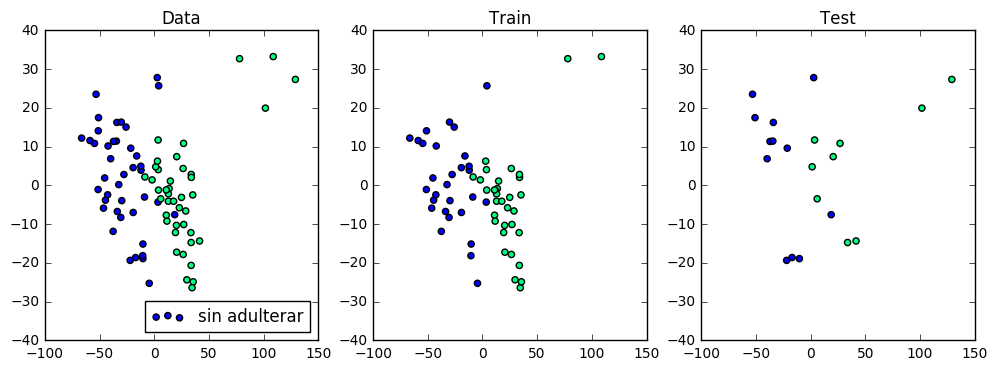

In [5]:
comp_p = pd.DataFrame(pipe.fit_transform(rest.iloc[:,:-1]))

# "pipe" replaces the 5 sentences below 
# sca = StandardScaler()
# pca = PCA(n_components=2, random_state=15) # 2 components = 97% variance
# comp_p = sca.fit_transform(rest.iloc[:,:-1])
# comp_p = pca.fit_transform(comp_p)
# print(np.sum(pca.explained_variance_ratio_))

train_x, test_x, train_y, test_y = train_test_split(comp_p, rest.iloc[:,-1:], test_size=.25)
print(train_x.shape, train_x.shape)

tr, ts = {"x":train_x.values, "y":train_y.values}, {"x":test_x.values, "y":test_y.values}
plot_data_train_test(comp_p.values, rest["clase"], tr, ts)

## a) Sudan 1 - 1%

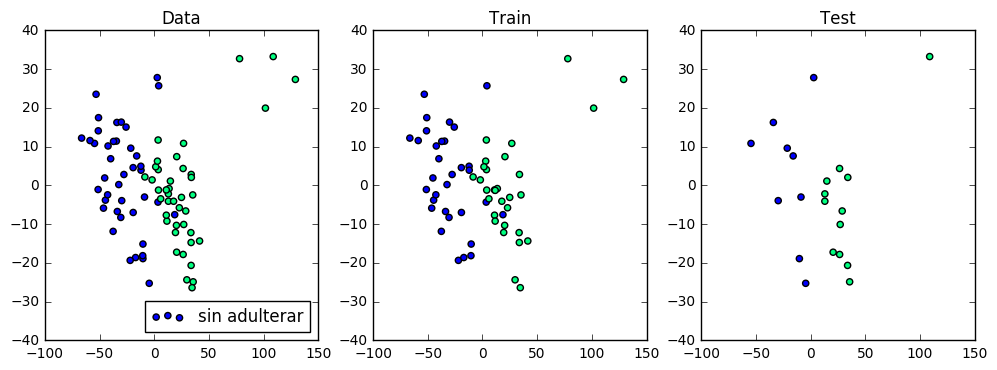

In [6]:
a_clases = ["sin adulterar", "sudan 1 - 1%"]
a_comp = load_par(a_clases)

a_comp_p = pd.DataFrame(pipe.fit_transform(a_comp.iloc[:,:-1]))

a_train_x, a_test_x, a_train_y, a_test_y = train_test_split(a_comp_p, a_comp["clase"], test_size=.25)
tr, ts = {"x":a_train_x.values, "y":a_train_y.values}, {"x":a_test_x.values, "y":a_test_y.values}
plot_data_train_test(a_comp_p.values, a_comp["clase"], tr, ts)

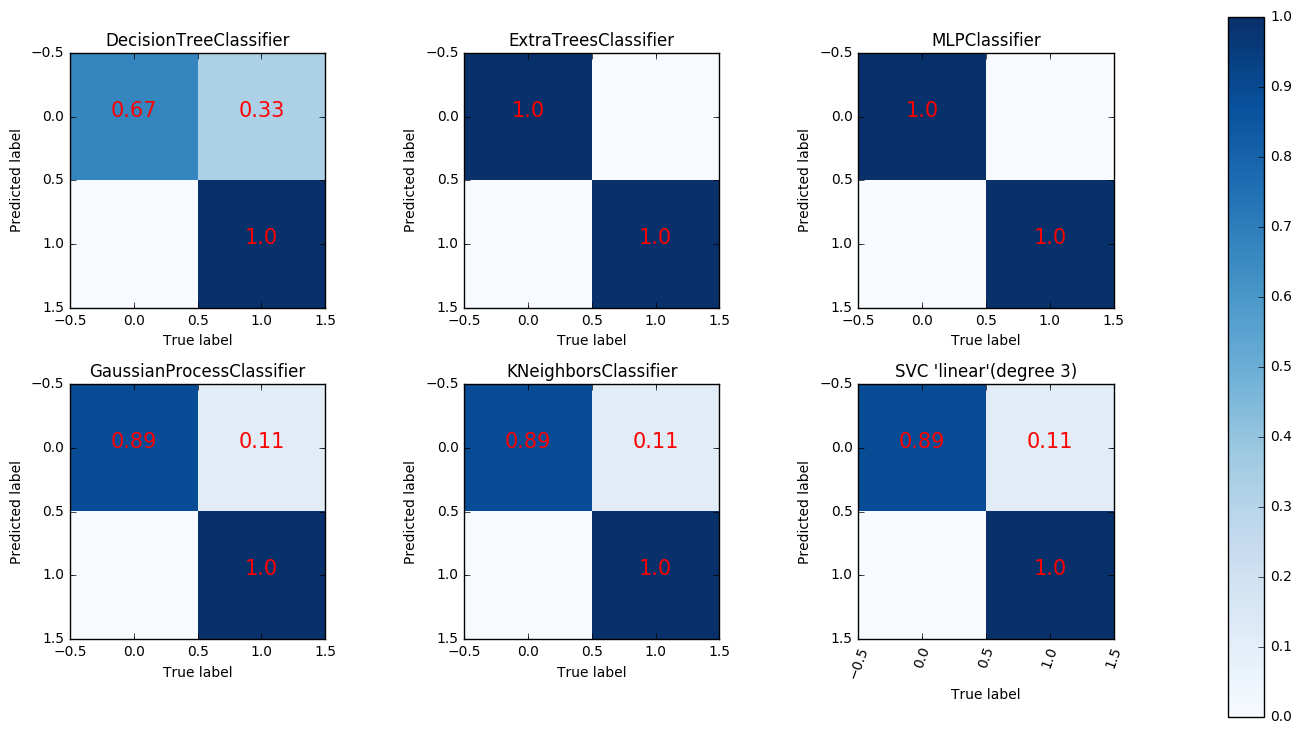

In [7]:
clasificar(a_train_x, a_train_y, a_test_x, a_test_y, a_clases, "linear", 3)

## b) Sudan 1 - 2,5%

(61, 2) (61,)


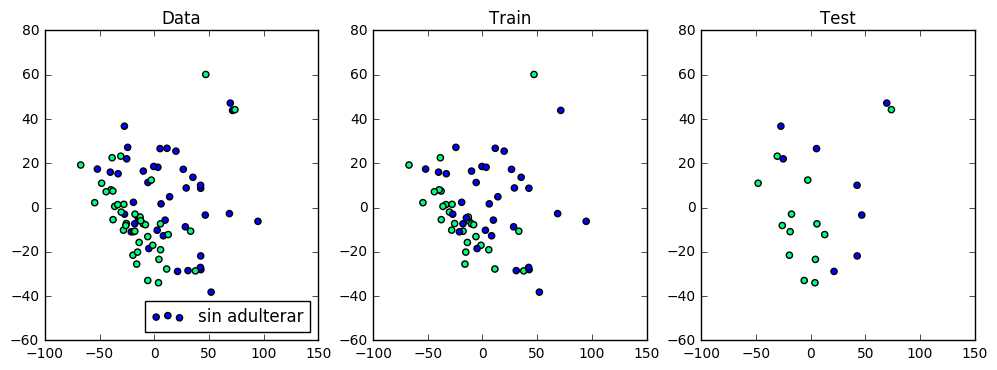

In [8]:
b_clases = ["sin adulterar", "sudan 1 - 2,5%"]
b_comp = load_par(b_clases)

b_comp_p = pd.DataFrame(pipe.fit_transform(b_comp.iloc[:,:-1]))

b_train_x, b_test_x, b_train_y, b_test_y = train_test_split(b_comp_p, b_comp["clase"], test_size=.25)
print(b_train_x.shape, b_train_y.shape)

b_train_x, b_test_x, b_train_y, b_test_y = train_test_split(b_comp_p, b_comp["clase"], test_size=.25)
tr, ts = {"x":b_train_x.values, "y":b_train_y.values}, {"x":b_test_x.values, "y":b_test_y.values}
plot_data_train_test(b_comp_p.values, b_comp["clase"], tr, ts)

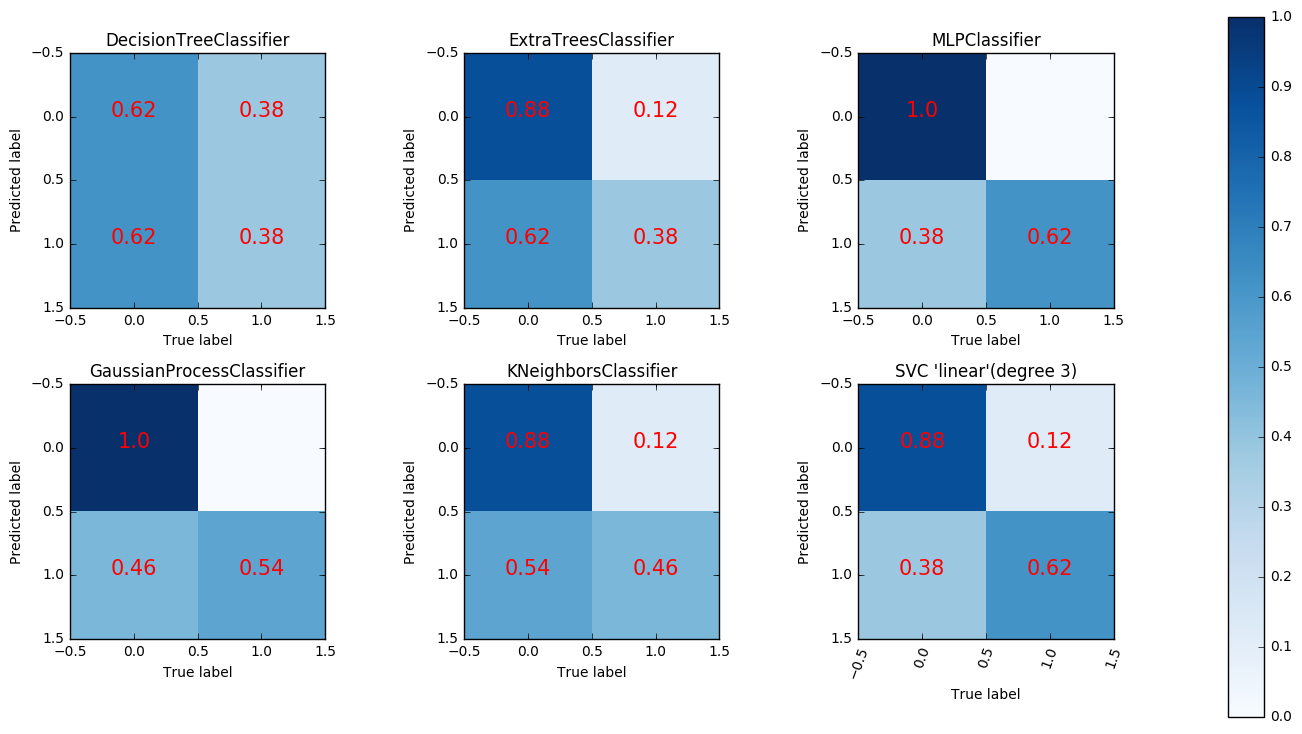

In [9]:
clasificar(b_train_x, b_train_y, b_test_x, b_test_y, b_clases, "linear", 3)

### Another aproach

(61, 1) (61,)


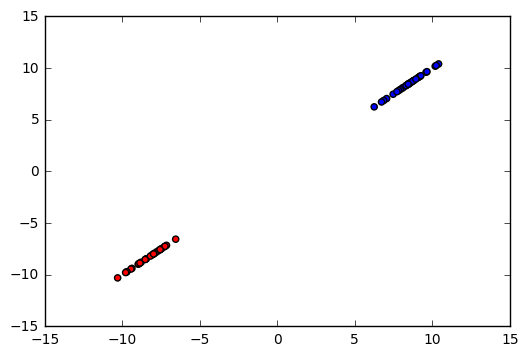

In [10]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

bo_clases = ["sin adulterar", "sudan 1 - 2,5%"]
bo_comp = load_par(bo_clases)

pipo = Pipeline([("sca", StandardScaler()),
#                  ("lda", LinearDiscriminantAnalysis(n_components=2) )# 2 components = 97% variance
                ])
bo_comp_p = pipo.fit_transform(bo_comp.iloc[:,:-1])#, bo_comp.iloc[:,-1:])

lda = LinearDiscriminantAnalysis(n_components=2)

bo_comp_p = lda.fit_transform(bo_comp_p[:,:-1], bo_comp["clase"])
bo_comp_p = pd.DataFrame(bo_comp_p)

b_train_x, b_test_x, b_train_y, b_test_y = train_test_split(bo_comp_p, bo_comp["clase"], test_size=.25)
print(b_train_x.shape, b_train_y.shape)

b_train_x, b_test_x, b_train_y, b_test_y = train_test_split(bo_comp_p, bo_comp["clase"], test_size=.25)

# tr, ts = {"x":b_train_x.values, "y":b_train_y.values}, {"x":b_test_x.values, "y":b_test_y.values}
# plot_data_train_test(bo_comp_p.values, bo_comp["clase"], tr, ts)

colors = ["r","b"]
colors = [colors[x] for x in b_train_y]
plt.figure()
plt.scatter(b_train_x, b_train_x, c=colors)
plt.show()

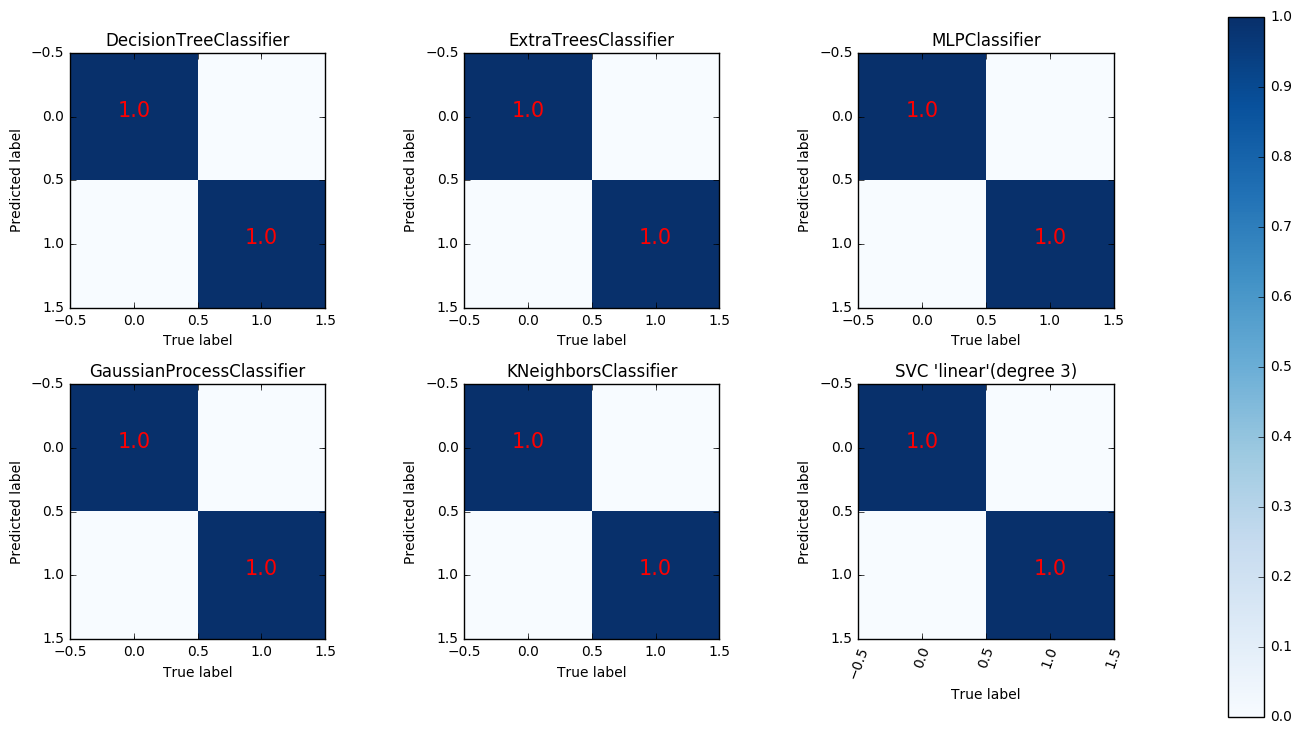

In [11]:
clasificar(b_train_x, b_train_y, b_test_x, b_test_y, bo_clases, "linear", 3)

## c) Sudan 1 - 5%

(62, 2) (62,)


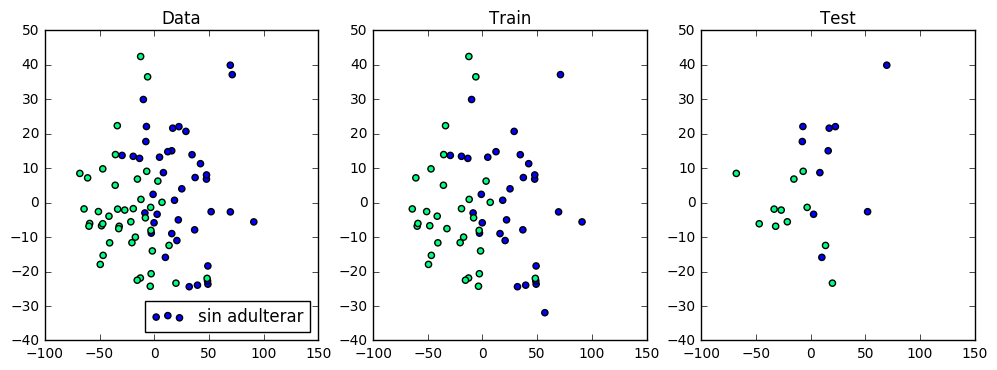

In [12]:
c_clases = ["sin adulterar", "sudan 1 - 5%"]
c_comp = load_par(c_clases)
c_comp_p = pd.DataFrame(pipe.fit_transform(c_comp.iloc[:,:-1]))

c_train_x, c_test_x, c_train_y, c_test_y = train_test_split(c_comp_p, c_comp["clase"], test_size=.25)
print(c_train_x.shape, c_train_y.shape)

c_train_x, c_test_x, c_train_y, c_test_y = train_test_split(c_comp_p, c_comp["clase"], test_size=.25)
tr, ts = {"x":c_train_x.values, "y":c_train_y.values}, {"x":c_test_x.values, "y":c_test_y.values}
plot_data_train_test(c_comp_p.values, c_comp["clase"], tr, ts)

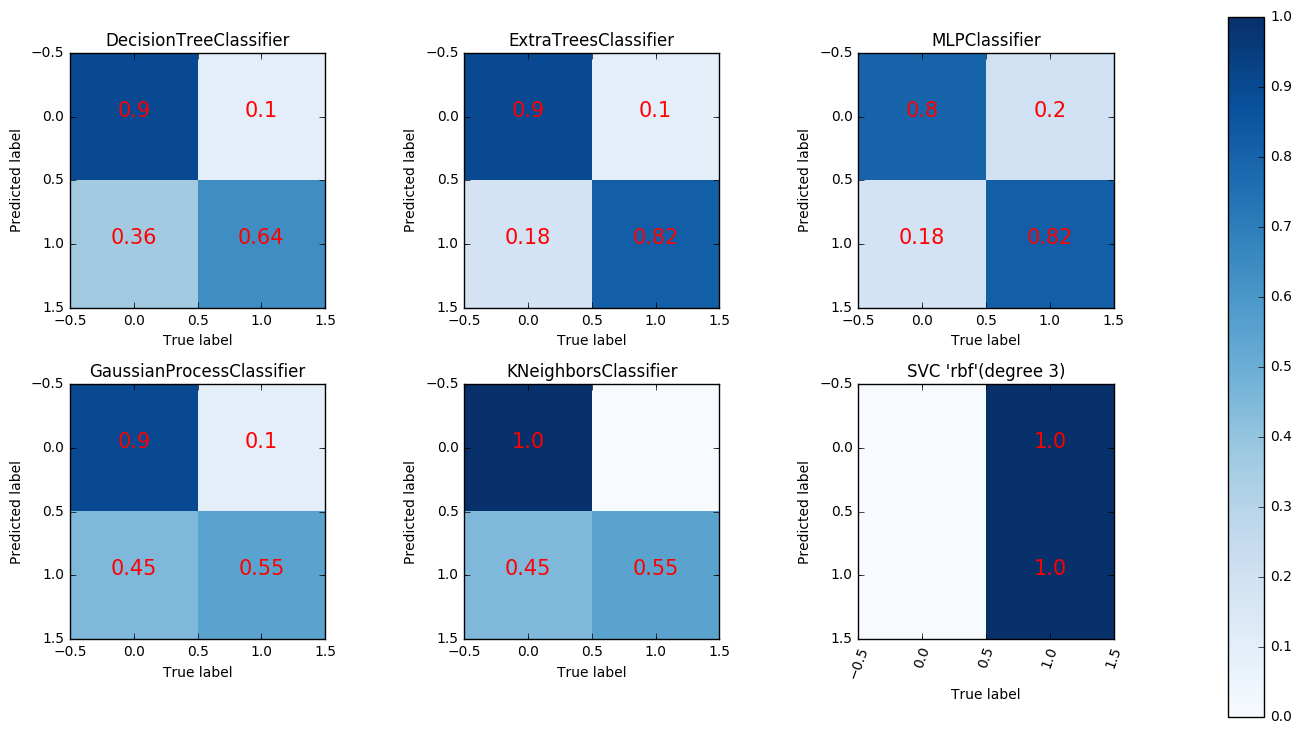

In [13]:
clasificar(c_train_x, c_train_y, c_test_x, c_test_y, c_clases, "rbf", 3)

### Another Aproach

(62, 1) (62,)


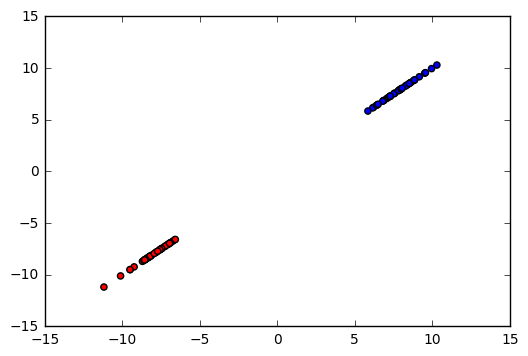

In [14]:
co_clases = ["sin adulterar", "sudan 1 - 5%"]
co_comp = load_par(co_clases)

pipo = Pipeline([("sca", StandardScaler()),
#                  ("lda", LinearDiscriminantAnalysis(n_components=2) )# 2 components = 97% variance
                ])
co_comp_p = pipo.fit_transform(co_comp.iloc[:,:-1])#, bo_comp.iloc[:,-1:])

lda = LinearDiscriminantAnalysis(n_components=2)

co_comp_p = lda.fit_transform(co_comp_p[:,:-1], co_comp["clase"])
co_comp_p = pd.DataFrame(co_comp_p)

c_train_x, c_test_x, c_train_y, c_test_y = train_test_split(co_comp_p, co_comp["clase"], test_size=.25)
print(c_train_x.shape, c_train_y.shape)

c_train_x, c_test_x, c_train_y, c_test_y = train_test_split(co_comp_p, co_comp["clase"], test_size=.25)

# tr, ts = {"x":b_train_x.values, "y":b_train_y.values}, {"x":b_test_x.values, "y":b_test_y.values}
# plot_data_train_test(bo_comp_p.values, bo_comp["clase"], tr, ts)

colors = ["r","b"]
colors = [colors[x] for x in co_comp["clase"]]
plt.figure()
plt.scatter(co_comp_p, co_comp_p, c=colors)
plt.show()

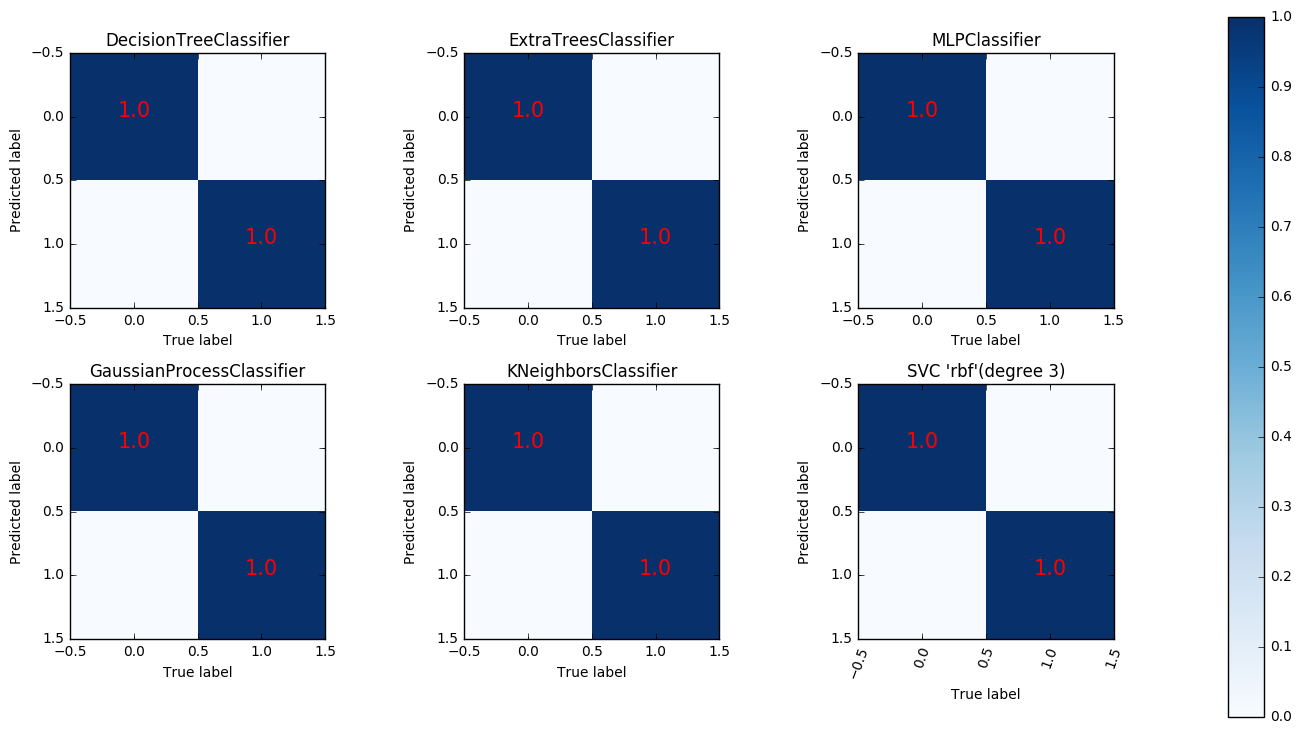

In [15]:
clasificar(c_train_x, c_train_y, c_test_x, c_test_y, co_clases, "rbf", 3)

# Sudan 1 (todos)

In [16]:
folds = ["sudan 1 - 1%", "sudan 1 - 2,5%", "sudan 1 - 5%"]

sin = cargar(one_row=True)

sudan_1 = pd.DataFrame()
for f in folds:
    aux = cargar(f, one_row=True, clase=1)
    sudan_1 = pd.concat([sudan_1, aux], ignore_index=True)

completos_1 = pd.DataFrame()
for i, row in sudan_1.iloc[:,:-1].iterrows():
    aux = sin_mean.iloc[:,:-1] - row
    completos_1 = pd.concat([completos_1, aux], ignore_index=True)

sin_p = pd.DataFrame()
for i, row in sin.iloc[:,:-1].iterrows():
    aux = sin_mean.iloc[:,:-1] - row
    sin_p = pd.concat([sin_p, aux], ignore_index=True)

sin_p["clase"] = 0
completos_1["clase"] = 1
completos_1 = pd.concat([completos_1, sin_p], ignore_index=True)
completos_1.shape

(166, 1558)

(124, 2) (124,)


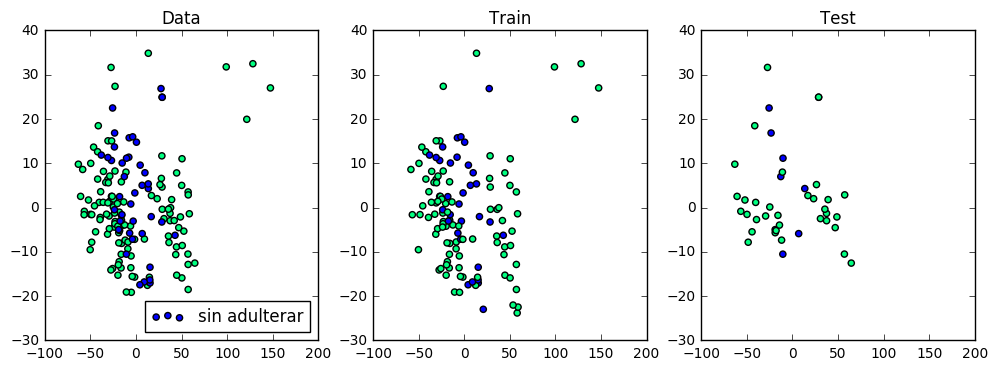

In [17]:
comp_p_sudan1 = pd.DataFrame(pipe.fit_transform(completos_1.iloc[:,:-1]))
s_train_x, s_test_x, s_train_y, s_test_y = train_test_split(comp_p_sudan1, completos_1["clase"], test_size=.25)
print(s_train_x.shape, s_train_y.shape)

s_clases = ["sin adulterar", "sudan 1"]
s_train_x, s_test_x, s_train_y, s_test_y = train_test_split(comp_p_sudan1, completos_1["clase"], test_size=.25)
tr, ts = {"x":s_train_x.values, "y":s_train_y.values}, {"x":s_test_x.values, "y":s_test_y.values}
plot_data_train_test(comp_p_sudan1.values, completos_1["clase"], tr, ts)

### Al tratar de unir las diferentes concentraciones, las semillas adulteradas se dispersan a ambos lados de las no adulteradas, por lo cual se dificulta la clasificación.

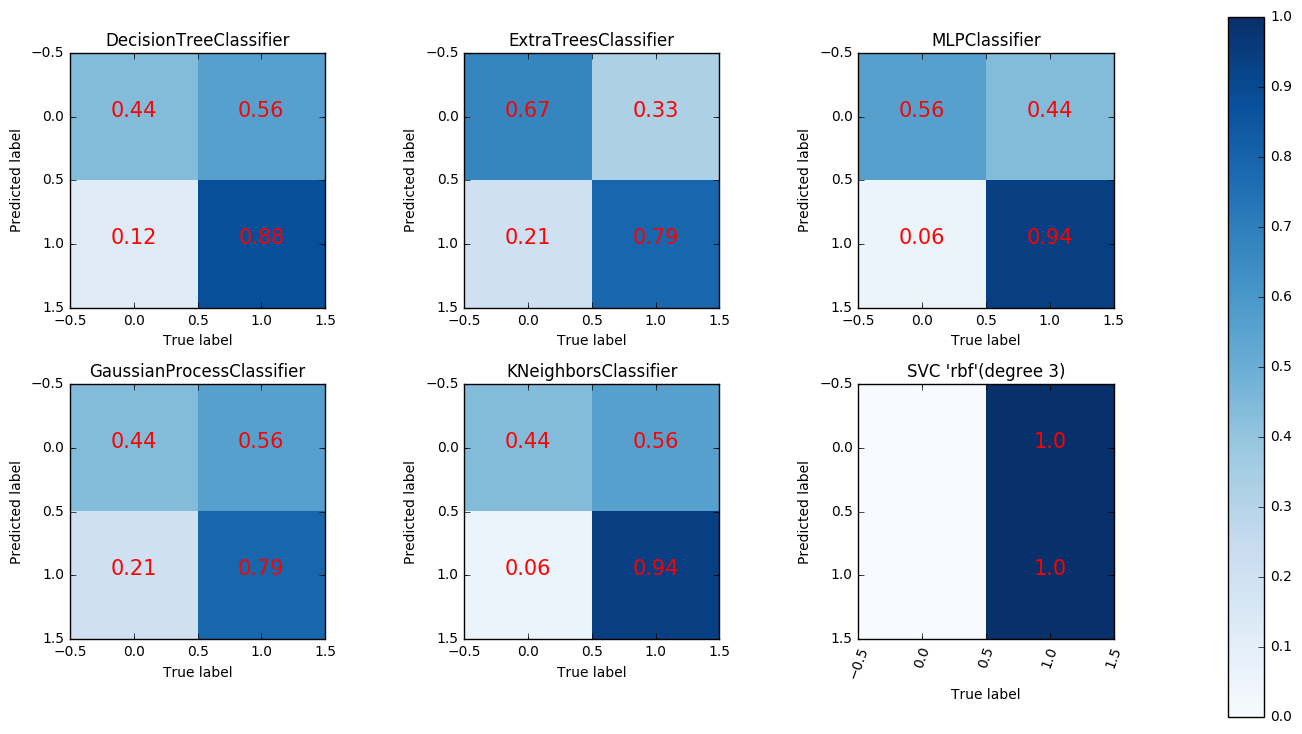

In [18]:
clasificar(s_train_x, s_train_y, s_test_x, s_test_y, s_clases, "rbf", 3)

### Another Aproach

In [19]:
folds = ["sudan 1 - 1%", "sudan 1 - 2,5%", "sudan 1 - 5%"]

sin = cargar(one_row=True)

sudan_1 = pd.DataFrame()
for f in folds:
    aux = cargar(f, one_row=True, clase=1)
    sudan_1 = pd.concat([sudan_1, aux], ignore_index=True)

completos_1 = pd.DataFrame()
for i, row in sudan_1.iloc[:,:-1].iterrows():
    aux = sin_mean.iloc[:,:-1] - row
    completos_1 = pd.concat([completos_1, aux], ignore_index=True)

sin_p = pd.DataFrame()
for i, row in sin.iloc[:,:-1].iterrows():
    aux = sin_mean.iloc[:,:-1] - row
    sin_p = pd.concat([sin_p, aux], ignore_index=True)

sin_p["clase"] = 0
completos_1["clase"] = 1
completos_1 = pd.concat([completos_1, sin_p], ignore_index=True)
completos_1.shape

(166, 1558)

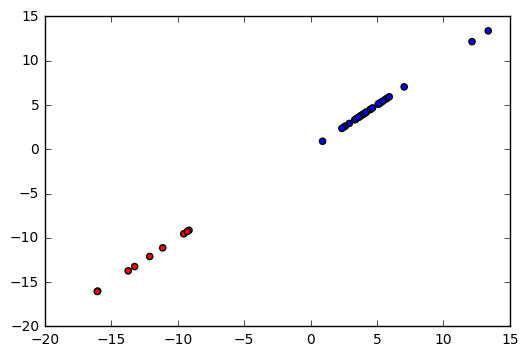

In [21]:
sca = StandardScaler()
lda = LinearDiscriminantAnalysis(n_components=2)
comp_p_sudan1 = sca.fit_transform(completos_1.iloc[:,:-1])

s_clases = ["sin adulterar", "sudan 1"]
s_train_x, s_test_x, s_train_y, s_test_y = train_test_split(comp_p_sudan1, completos_1["clase"], test_size=.25)

ss_train_x = lda.fit_transform(s_train_x, s_train_y)

ss_test_x = lda.transform(s_test_x)
# comp_p_sudan1 = pd.DataFrame(lda.fit_transform(comp_p_sudan1[:,:-1], completos_1["clase"]))


plt.figure()
co = ["r","b"]
colores = [co[x] for x in s_test_y]
plt.scatter(ss_test_x, ss_test_x, c=colores)
plt.show()

In [22]:
ss_train_x.shape

(124, 1)

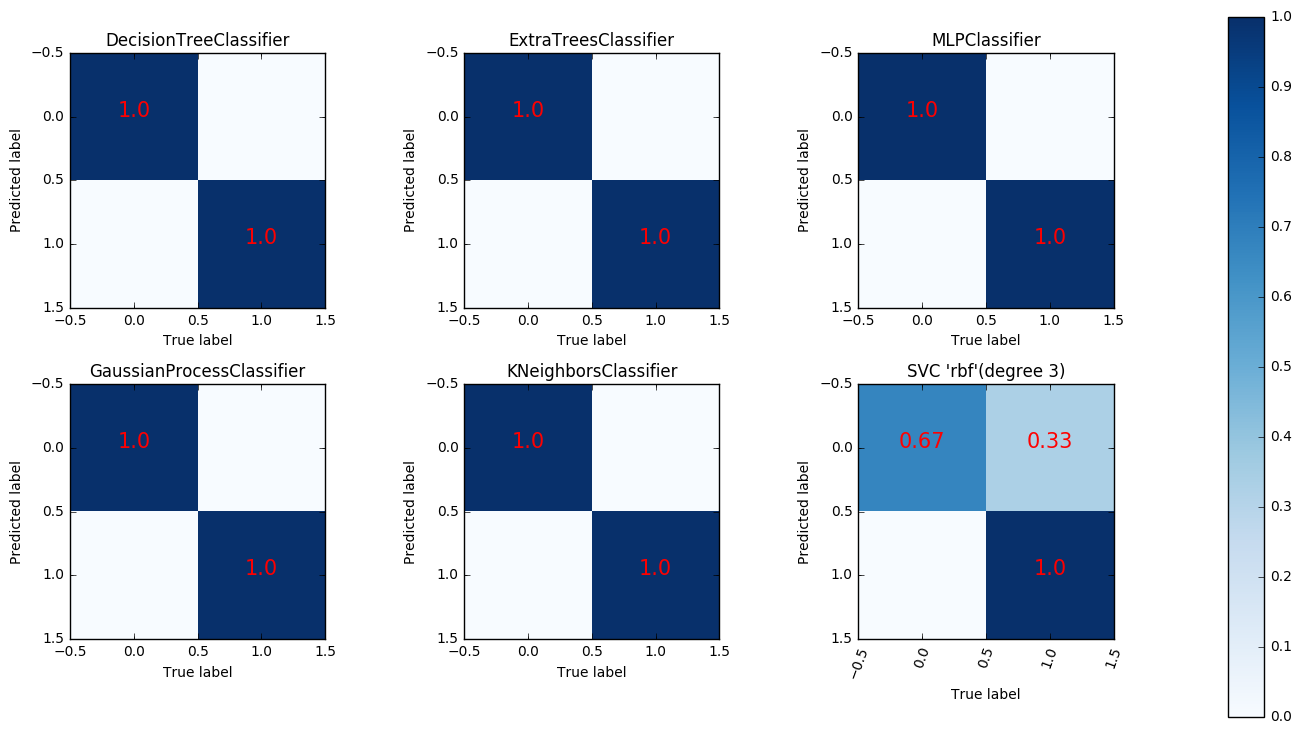

In [23]:
clasificar(ss_train_x, s_train_y, ss_test_x, s_test_y, s_clases, "rbf", 3)

## d) Sudan 2 - 1%

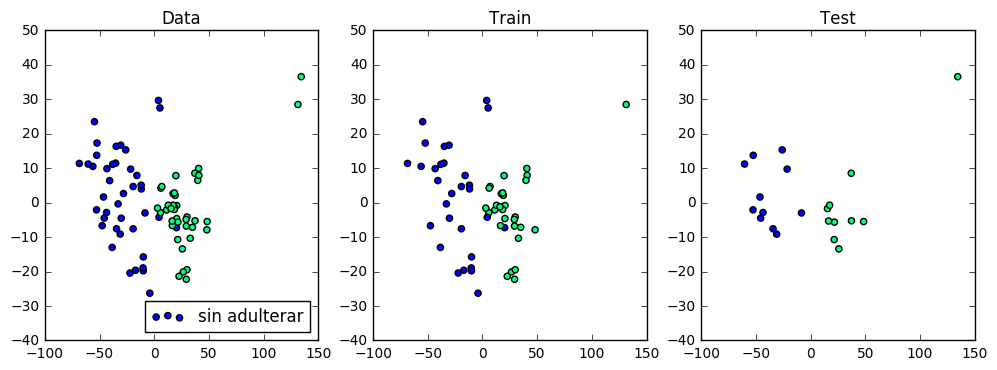

In [24]:
d_clases = ["sin adulterar", "sudan 2 - 1%"]
d_comp = load_par(d_clases)
d_comp_p = pd.DataFrame(pipe.fit_transform(d_comp.iloc[:,:-1]))

d_train_x, d_test_x, d_train_y, d_test_y = train_test_split(d_comp_p, d_comp["clase"], test_size=.25)
tr, ts = {"x":d_train_x.values, "y":d_train_y.values}, {"x":d_test_x.values, "y":d_test_y.values}
plot_data_train_test(d_comp_p.values, d_comp["clase"], tr, ts)

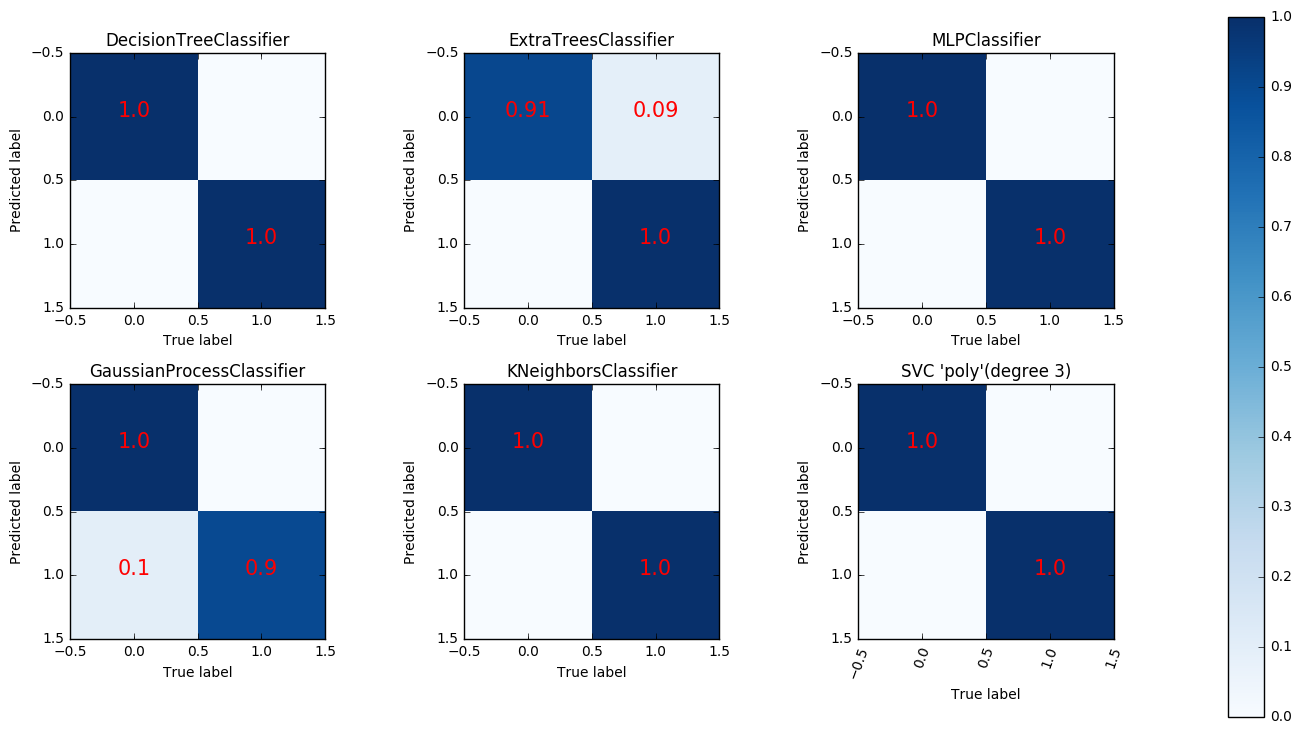

In [25]:
clasificar(d_train_x, d_train_y, d_test_x, d_test_y, d_clases, "poly", 3)

## e) Sudan 2 - 2,5%

(60, 2) (60,)


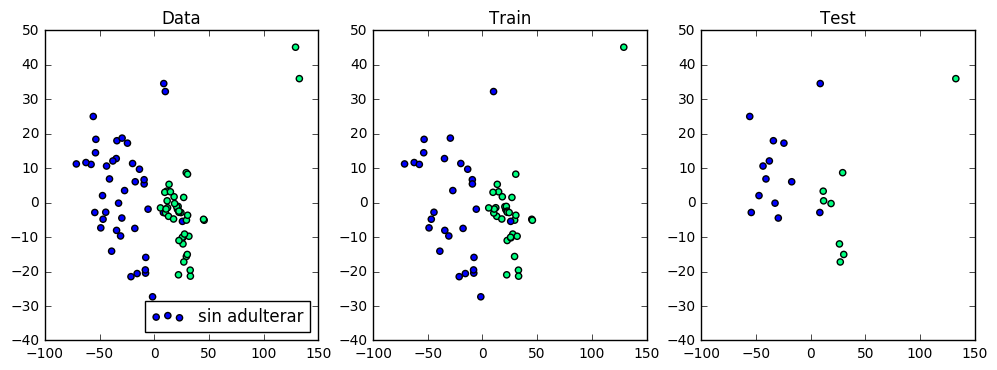

In [26]:
e_clases = ["sin adulterar", "sudan 2 - 2,5%"]
e_comp = load_par(e_clases)
e_comp_p = pd.DataFrame(pipe.fit_transform(e_comp.iloc[:,:-1]))

e_train_x, e_test_x, e_train_y, e_test_y = train_test_split(e_comp_p, e_comp["clase"], test_size=.25)
print(e_train_x.shape, e_train_y.shape)
tr, ts = {"x":e_train_x.values, "y":e_train_y.values}, {"x":e_test_x.values, "y":e_test_y.values}
plot_data_train_test(e_comp_p.values, e_comp["clase"], tr, ts)

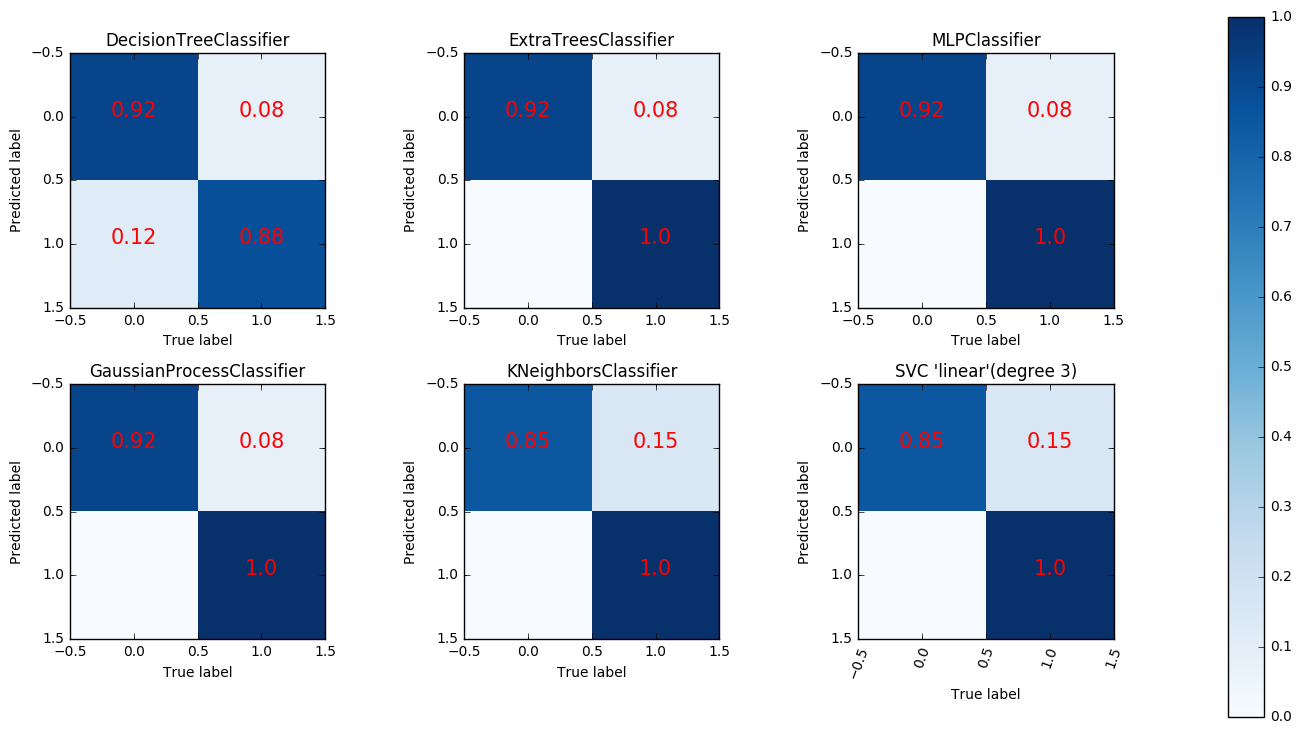

In [27]:
clasificar(e_train_x, e_train_y, e_test_x, e_test_y, e_clases, "linear", 3)

## f) Sudan 2 - 5%

(60, 2) (60,)


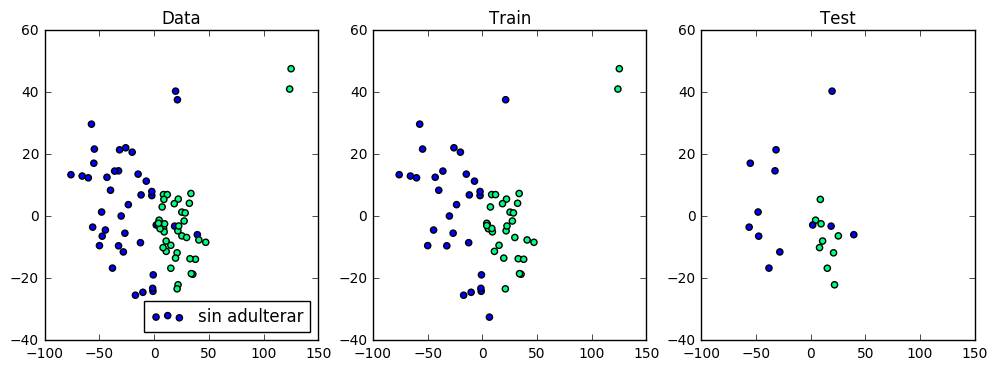

In [28]:
f_clases = ["sin adulterar", "sudan 2 - 5%"]
f_comp = load_par(f_clases)
f_comp_p = pd.DataFrame(pipe.fit_transform(f_comp.iloc[:,:-1]))

f_train_x, f_test_x, f_train_y, f_test_y = train_test_split(f_comp_p, f_comp["clase"], test_size=.25)
print(f_train_x.shape, f_train_y.shape)
tr, ts = {"x":f_train_x.values, "y":f_train_y.values}, {"x":f_test_x.values, "y":f_test_y.values}
plot_data_train_test(f_comp_p.values, f_comp["clase"], tr, ts)

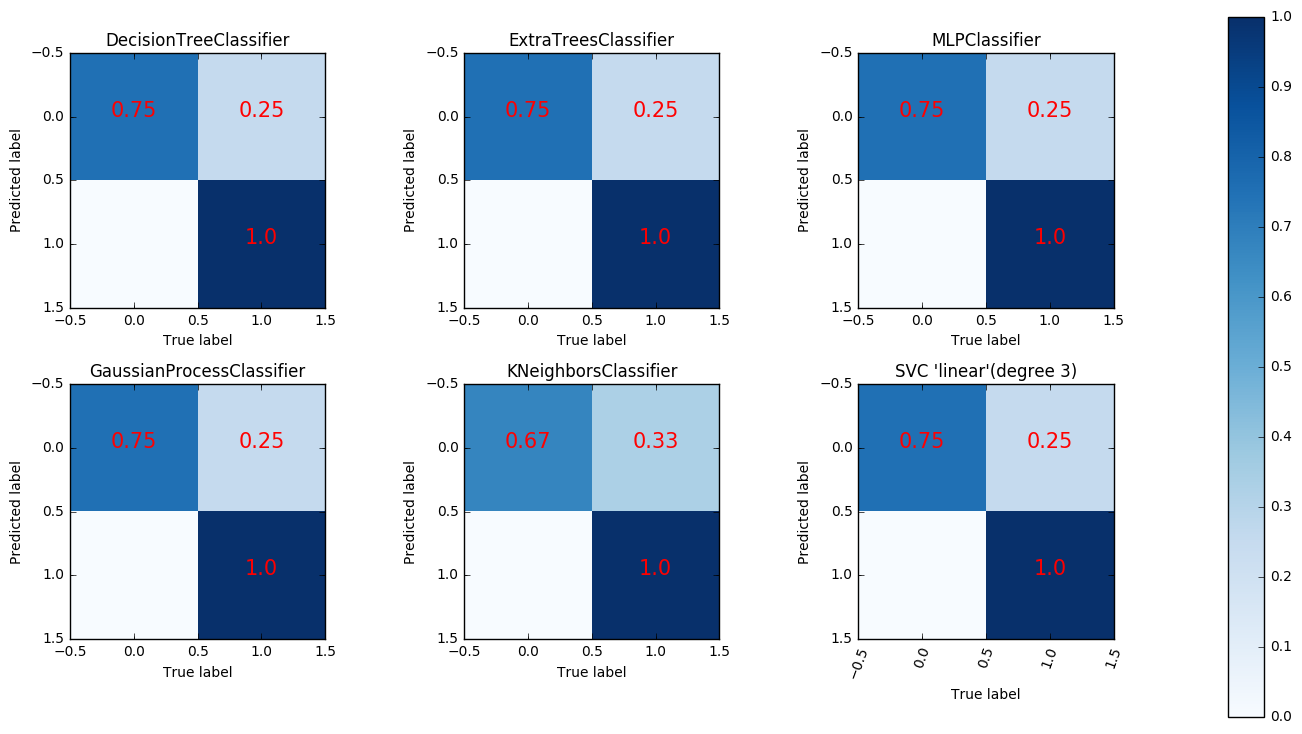

In [29]:
clasificar(f_train_x, f_train_y, f_test_x, f_test_y, f_clases, "linear", 3)

## Sudan 2 (todos)

In [30]:
folds = ["sudan 2 - 1%", "sudan 2 - 2,5%", "sudan 2 - 5%"]
sin = cargar(one_row=True)

sudan_2 = pd.DataFrame()
for f in folds:
    aux = cargar(f, one_row=True, clase=1)
    sudan_2 = pd.concat([sudan_2, aux], ignore_index=True)

completos_2 = pd.DataFrame()
for i, row in sudan_2.iloc[:,:-1].iterrows():
    aux = sin_mean.iloc[:,:-1] - row
    completos_2 = pd.concat([completos_2, aux], ignore_index=True)

sin_p = pd.DataFrame()
for i, row in sin.iloc[:,:-1].iterrows():
    aux = sin_mean.iloc[:,:-1] - row
    sin_p = pd.concat([sin_p, aux], ignore_index=True)
sin_p["clase"] = 0
completos_2["clase"] = 1
completos_2 = pd.concat([completos_2, sin_p], ignore_index=True)

completos_2.shape

(161, 1558)

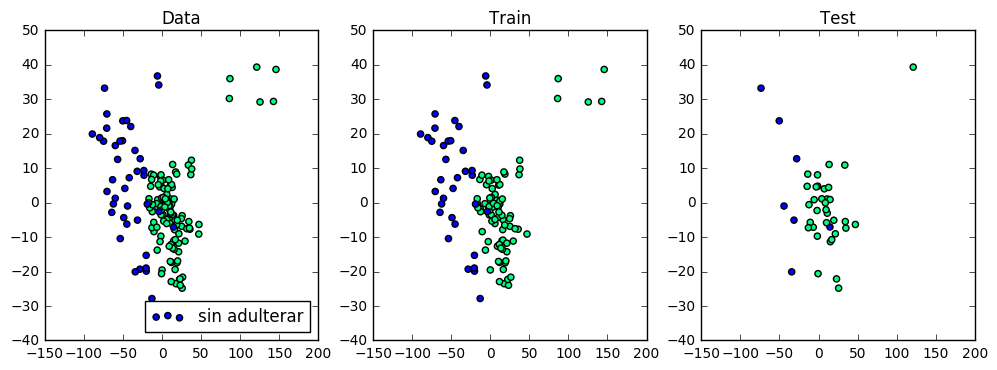

In [31]:
pipe_s2 = Pipeline([("sca", StandardScaler()),
                    ("pca", PCA(n_components=2, random_state=15)), # 2 components = 97% variance
                ])
comp_p_sudan2 = pd.DataFrame(pipe_s2.fit_transform(completos_2.iloc[:,:-1]))

s2_clases = ["sin adulterar", "sudan 2"]
s2_train_x, s2_test_x, s2_train_y, s2_test_y = train_test_split(comp_p_sudan2, completos_2["clase"], test_size=.25)

tr, ts = {"x":s2_train_x.values, "y":s2_train_y.values}, {"x":s2_test_x.values, "y":s2_test_y.values}
plot_data_train_test(comp_p_sudan2.values, completos_2["clase"], tr, ts)

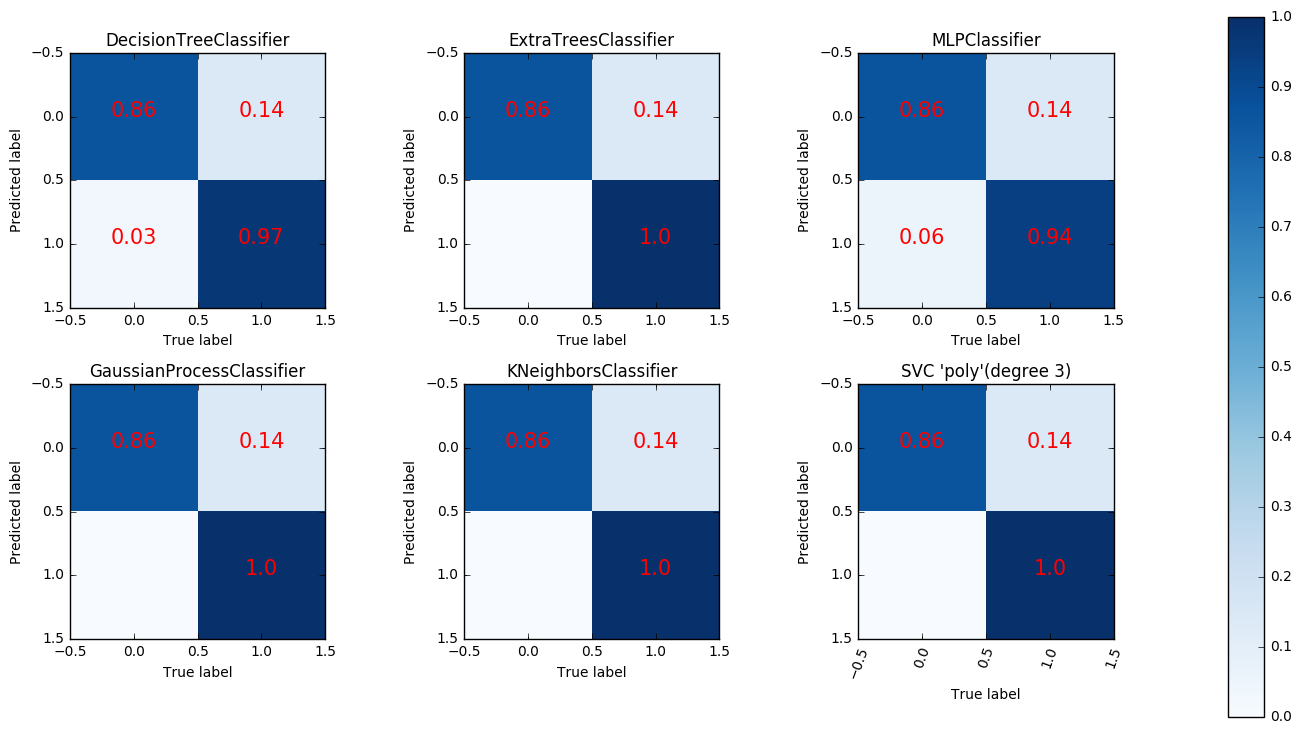

In [32]:
clasificar(s2_train_x, s2_train_y, s2_test_x, s2_test_y, s2_clases, "poly", 3)

## g) para red 1%

(60, 2) (60,)


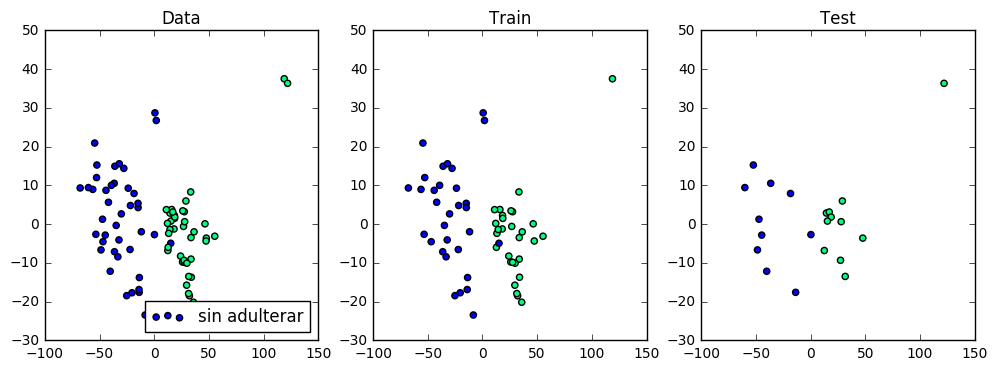

In [33]:
g_clases = ["sin adulterar", "para red - 1%"]
g_comp = load_par(g_clases)
g_comp_p = pd.DataFrame(pipe.fit_transform(g_comp.iloc[:,:-1]))

g_train_x, g_test_x, g_train_y, g_test_y = train_test_split(g_comp_p, g_comp["clase"], test_size=.25)
print(g_train_x.shape, g_train_y.shape)
tr, ts = {"x":g_train_x.values, "y":g_train_y.values}, {"x":g_test_x.values, "y":g_test_y.values}
plot_data_train_test(g_comp_p.values, g_comp["clase"], tr, ts)

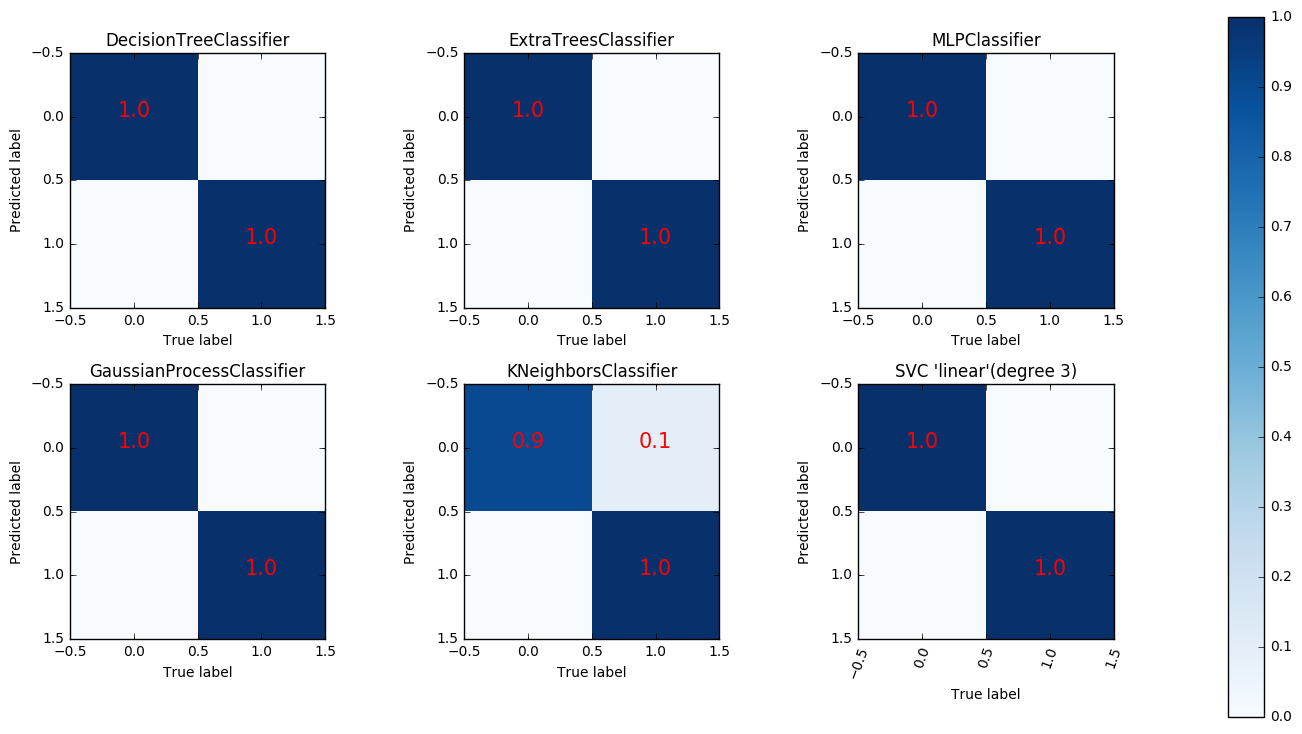

In [34]:
clasificar(g_train_x, g_train_y, g_test_x, g_test_y, g_clases, "linear", 3)

## h) para red - 2,5%

(60, 2) (60,)


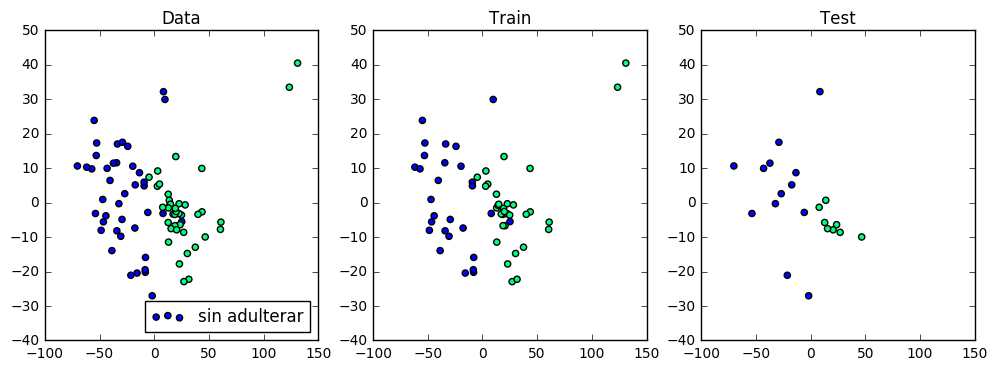

In [35]:
h_clases = ["sin adulterar", "para red - 2,5%/"]
h_comp = load_par(h_clases)
h_comp_p = pd.DataFrame(pipe.fit_transform(h_comp.iloc[:,:-1]))

h_train_x, h_test_x, h_train_y, h_test_y = train_test_split(h_comp_p, h_comp["clase"], test_size=.25)
print(h_train_x.shape, h_train_y.shape)
tr, ts = {"x":h_train_x.values, "y":h_train_y.values}, {"x":h_test_x.values, "y":h_test_y.values}
plot_data_train_test(h_comp_p.values, h_comp["clase"], tr, ts)

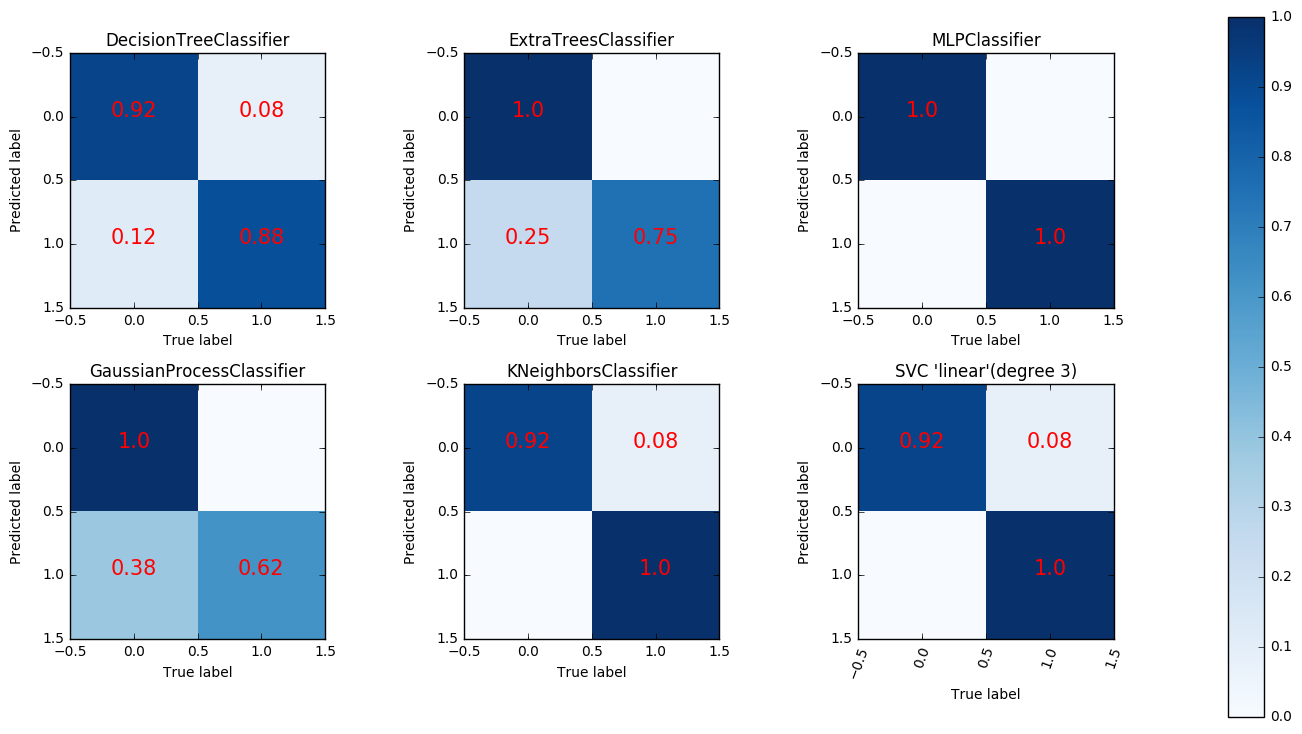

In [36]:
clasificar(h_train_x, h_train_y, h_test_x, h_test_y, h_clases, "linear", 3)

## i) para red - 5%

(60, 2) (60,)


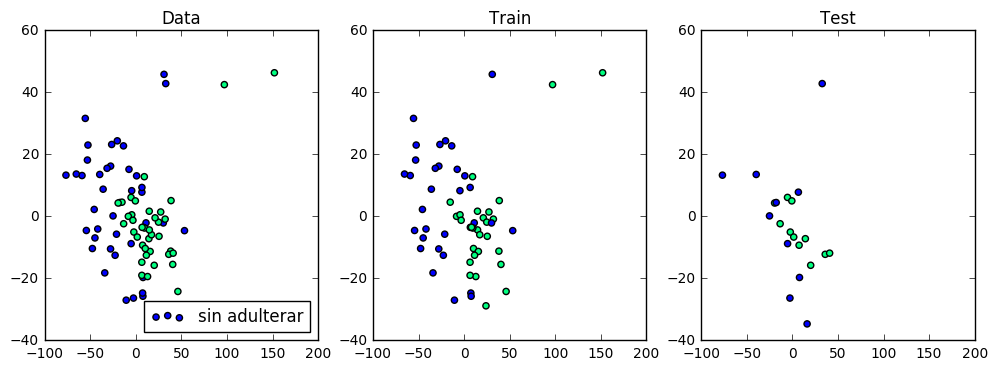

In [37]:
i_clases = ["sin adulterar", "para red - 5%"]
i_comp = load_par(i_clases)
i_comp_p = pd.DataFrame(pipe.fit_transform(i_comp.iloc[:,:-1]))

i_train_x, i_test_x, i_train_y, i_test_y = train_test_split(i_comp_p, i_comp["clase"], test_size=.25)
print(i_train_x.shape, i_train_y.shape)
tr, ts = {"x":i_train_x.values, "y":i_train_y.values}, {"x":i_test_x.values, "y":i_test_y.values}
plot_data_train_test(i_comp_p.values, i_comp["clase"], tr, ts)

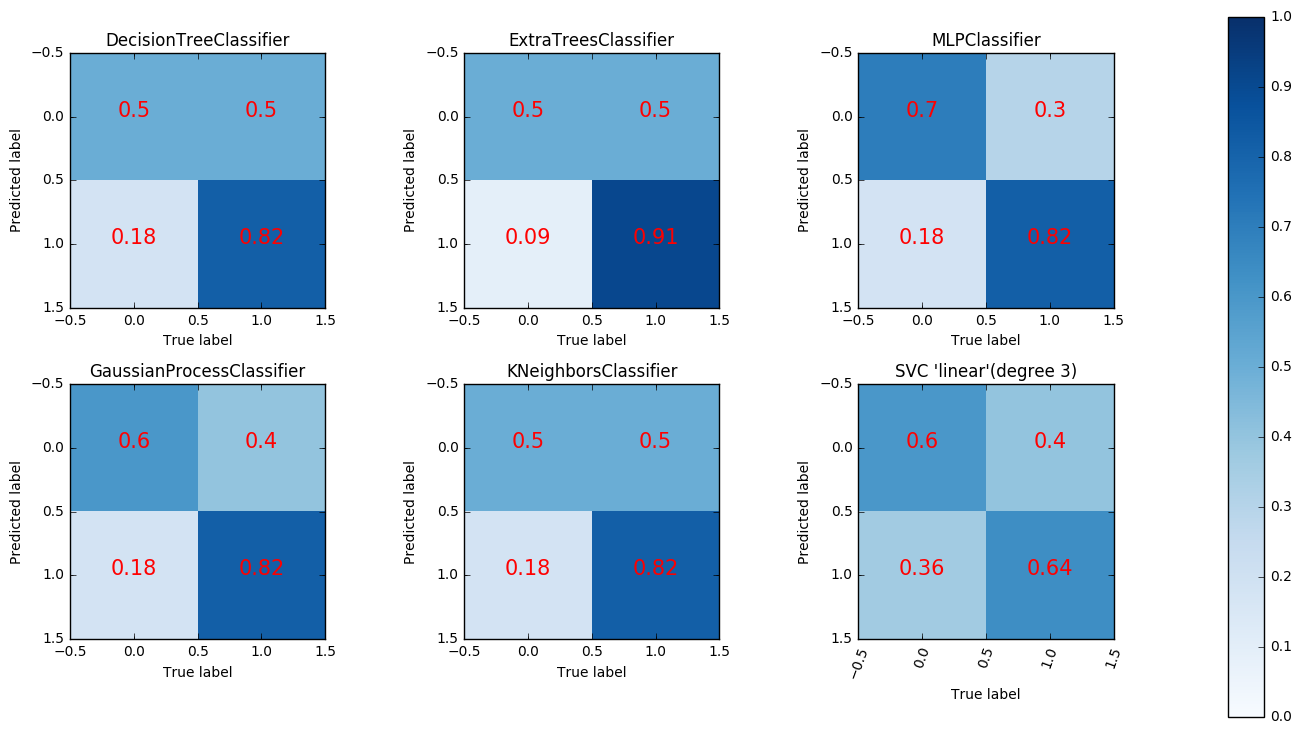

In [38]:
clasificar(i_train_x, i_train_y, i_test_x, i_test_y, i_clases, "linear", 3)

## para red (todos)

In [39]:
folds = ["para red - 1%", "para red - 2,5%", "para red - 5%"]
sin = cargar(one_row=True)

parared_2 = pd.DataFrame()
for f in folds:
    aux = cargar(f, one_row=True, clase=1)
    parared_2 = pd.concat([parared_2, aux], ignore_index=True)

parared_comp = pd.DataFrame()
for i, row in parared_2.iloc[:,:-1].iterrows():
    aux = sin_mean.iloc[:,:-1] - row
    parared_comp = pd.concat([parared_comp, aux], ignore_index=True)

sin_p = pd.DataFrame()
for i, row in sin.iloc[:,:-1].iterrows():
    aux = sin_mean.iloc[:,:-1] - row
    sin_p = pd.concat([sin_p, aux], ignore_index=True)

sin_p["clase"] = 0
parared_comp["clase"] = 1
parared_comp = pd.concat([parared_comp, sin_p], ignore_index=True)

parared_comp.shape

(161, 1558)

In [40]:
para_pipe = Pipeline([("sca", StandardScaler()),
                    ("pca", PCA(n_components=2, random_state=15)), # 2 components = 97% variance
                ])
parared_comp_p = pd.DataFrame(para_pipe.fit_transform(parared_comp.iloc[:,:-1]))

p_train_x, p_test_x, p_train_y, p_test_y = train_test_split(parared_comp_p, parared_comp["clase"], test_size=.25)
print(p_train_x.shape, p_train_y.shape)

(120, 2) (120,)


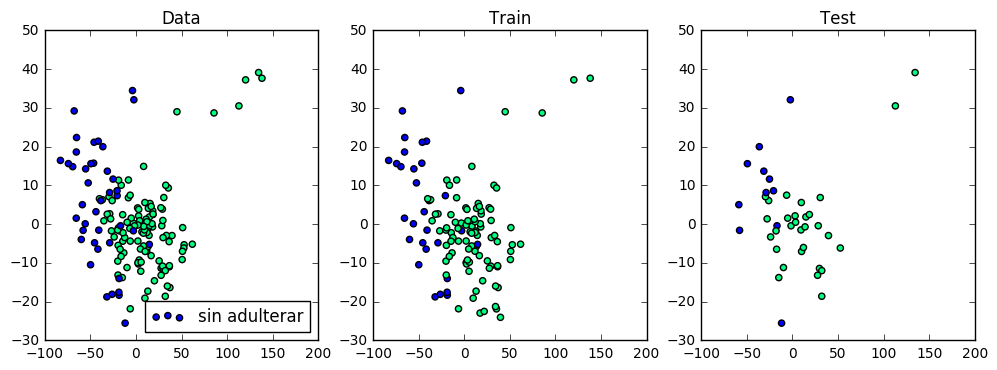

In [41]:
p_clases = ["sin adulterar", "para red"]

p_train_x, p_test_x, p_train_y, p_test_y = train_test_split(parared_comp_p, parared_comp["clase"], test_size=.25)
tr, ts = {"x":p_train_x.values, "y":p_train_y.values}, {"x":p_test_x.values, "y":p_test_y.values}
plot_data_train_test(parared_comp_p.values, parared_comp["clase"], tr, ts)

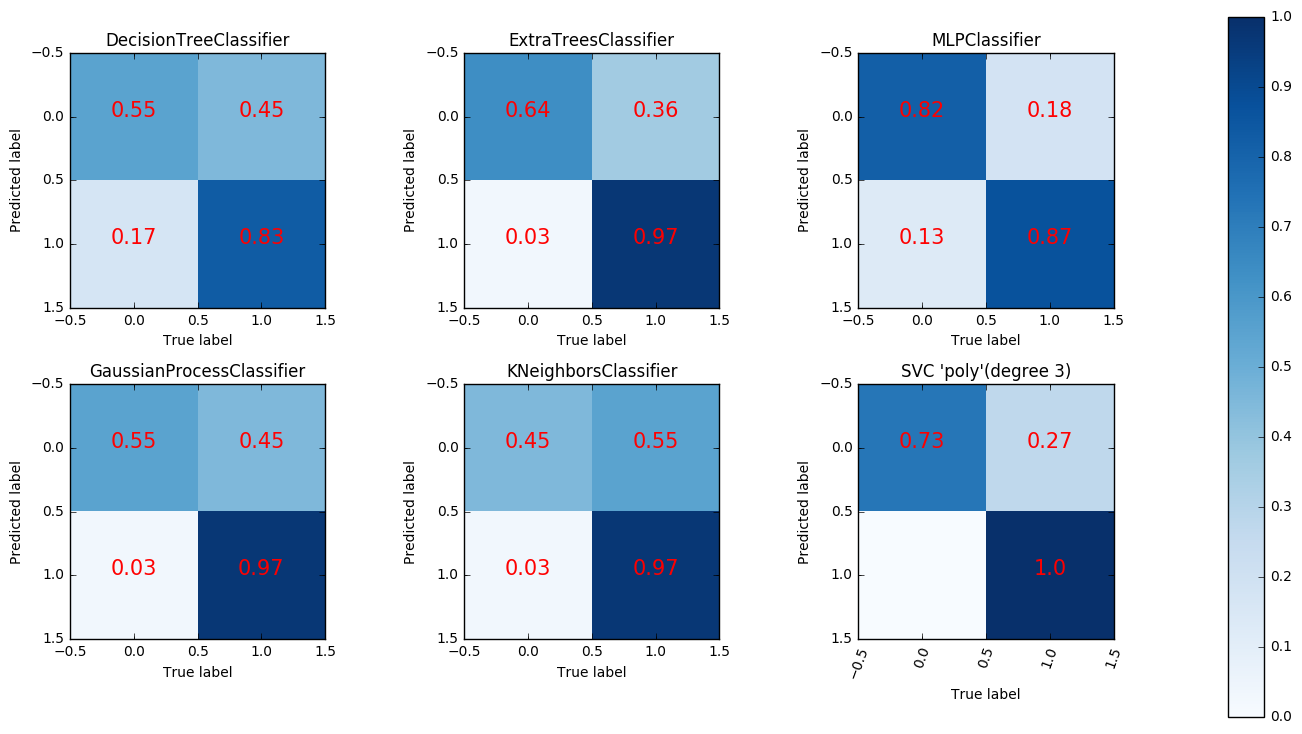

In [42]:
clasificar(p_train_x, p_train_y, p_test_x, p_test_y, p_clases, "poly", 3)